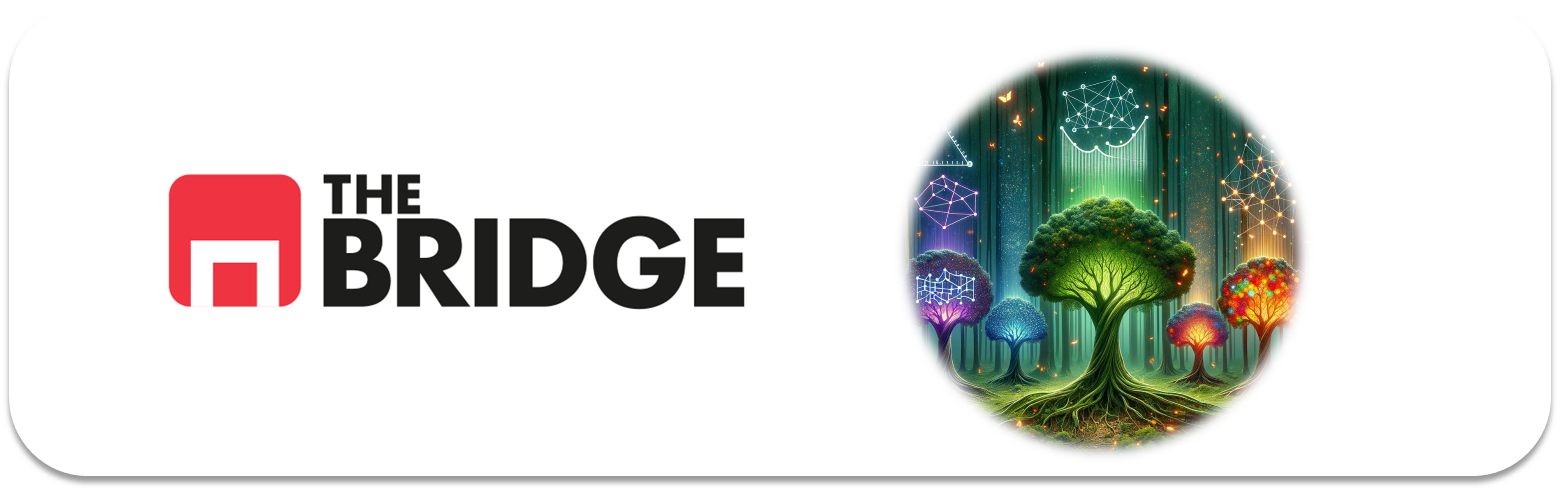

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

1. Entender el problema de negocio y trasladarlo a un problema técnico: supervisado, regresión o clasificación.

Es un problema supervisado. Incluso en el dataset está nuestra y (target) y se trata de un problema de clasificación (contratará o no contratará)

2. Obtener datos

In [2]:
df = pd.read_csv("./data/bank-full.csv", delimiter = ";")
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
17703,57,services,married,secondary,no,1301,yes,no,cellular,29,jul,63,2,-1,0,unknown,no
24439,56,admin.,married,secondary,no,1270,yes,no,cellular,17,nov,80,2,165,2,other,no
14655,27,admin.,single,secondary,no,454,no,yes,cellular,15,jul,331,2,-1,0,unknown,no
32654,30,blue-collar,married,secondary,no,5,no,no,cellular,17,apr,840,3,-1,0,unknown,yes
37367,35,blue-collar,married,secondary,no,328,yes,no,cellular,13,may,484,3,364,1,other,no


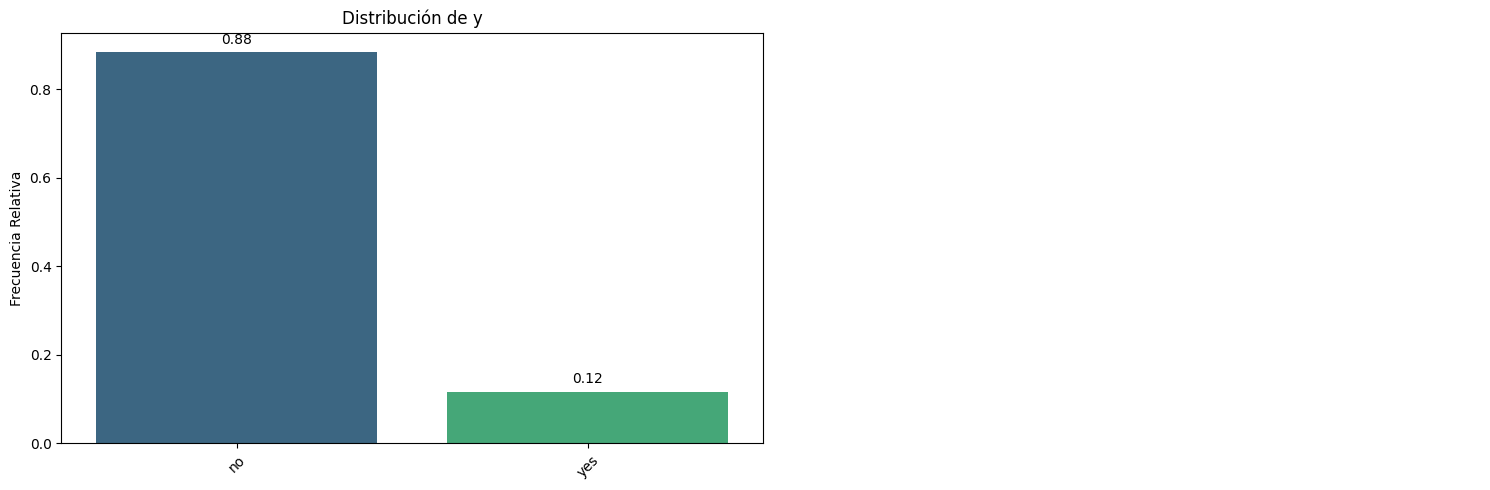

In [3]:
target = "y"

# Tenemmos variables categórica sy numéricas que vamos a comparar con nuestro target del modelo supervisado.
bt.pinta_distribucion_categoricas(df, [target], relativa = True, mostrar_valores = True)

3. Visualización, ojeo de los datos

In [4]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

           Card     %_Card    Tipo      tipo_sugerido
age          77   0.170313   int64  Numerica discreta
job          12   0.026542  object         Categorica
marital       3   0.006636  object         Categorica
education     4   0.008847  object         Categorica
default       2   0.004424  object            Binaria
balance    7168  15.854549   int64  Numerica discreta
housing       2   0.004424  object            Binaria
loan          2   0.004424  object            Binaria
contact       3   0.006636  object         Categorica
day          31   0.068567   int64  Numerica discreta
month        12   0.026542  object         Categorica
duration   1573   3.479242   int64  Numerica discreta
campaign     48   0.106169   int64  Numerica discreta
pdays       559   1.236425   int64  Numerica discreta
previous     41   0.090686   int64  Numerica discreta
poutcome      4   0.008847  object         Categorica
y             2   0.004424  object            Binaria


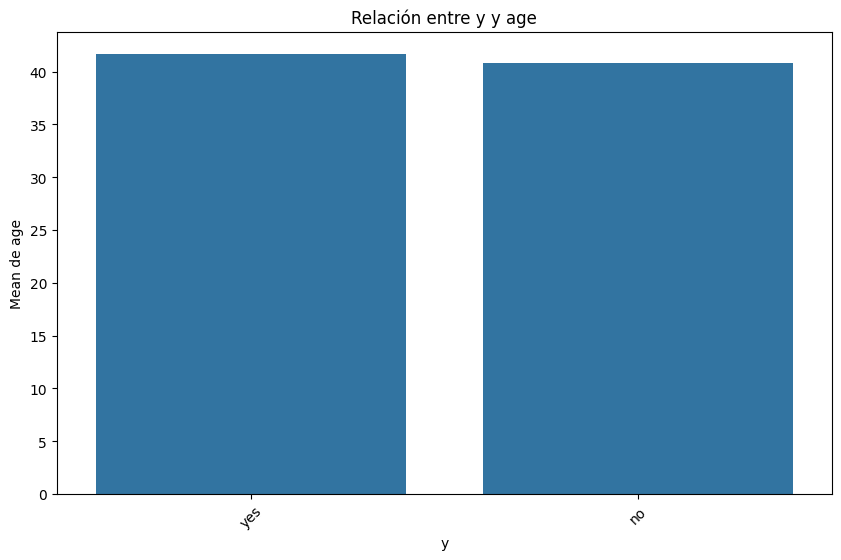

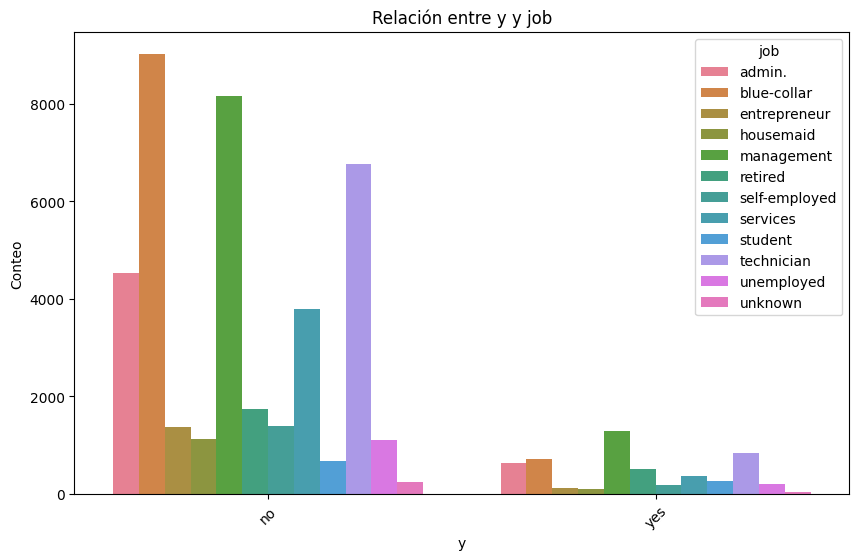

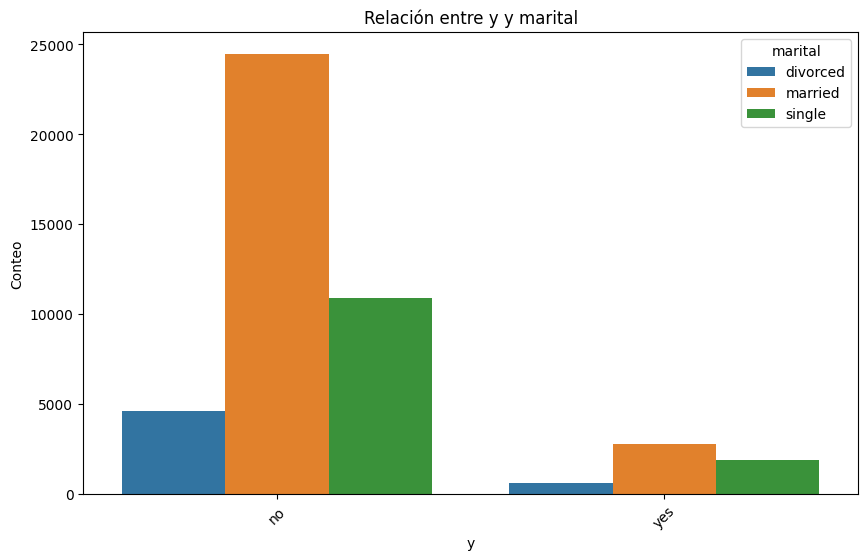

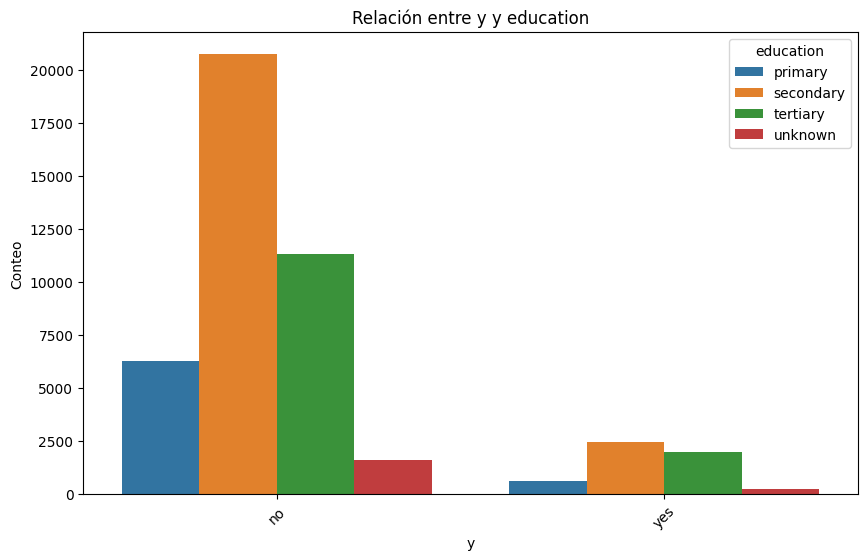

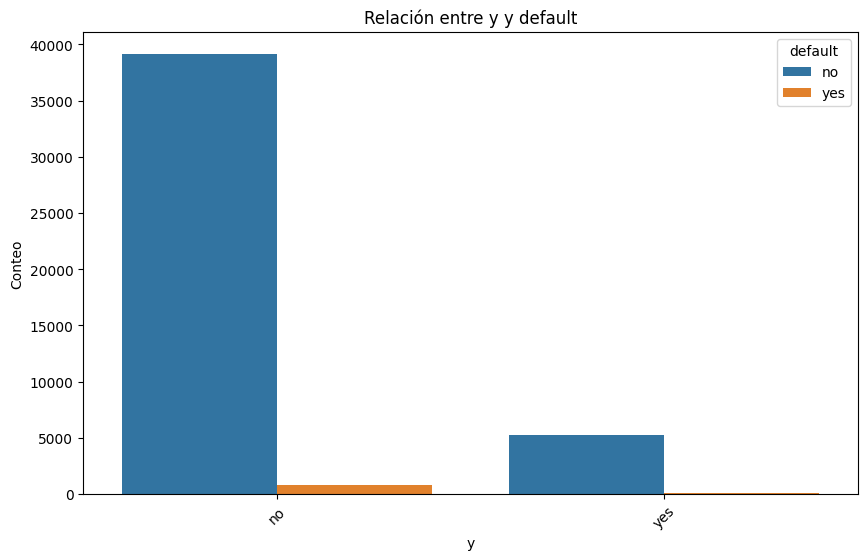

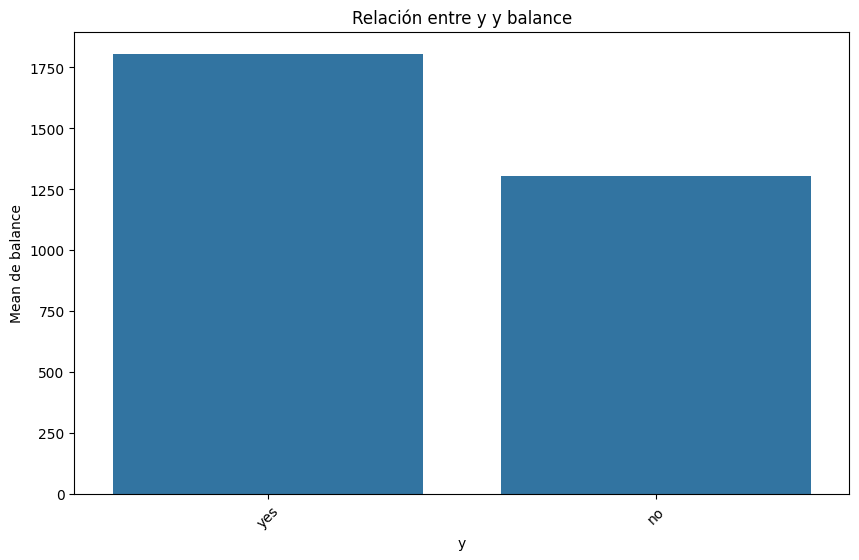

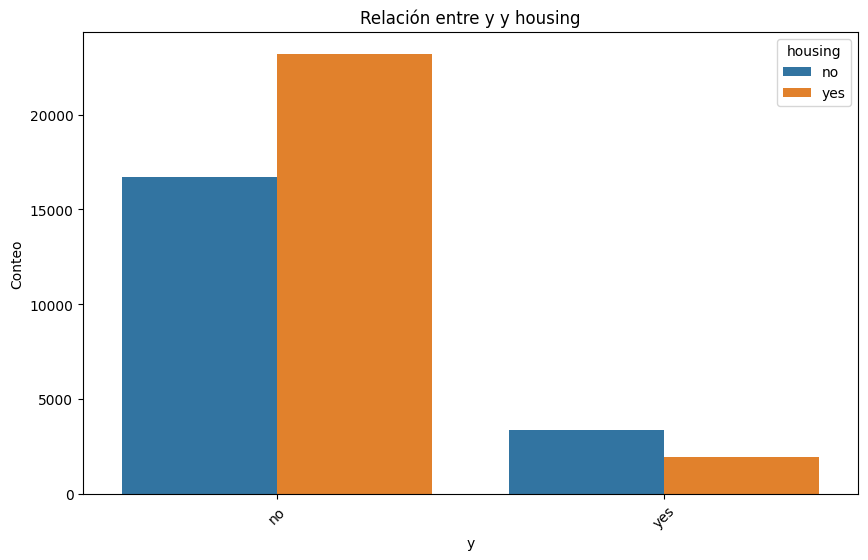

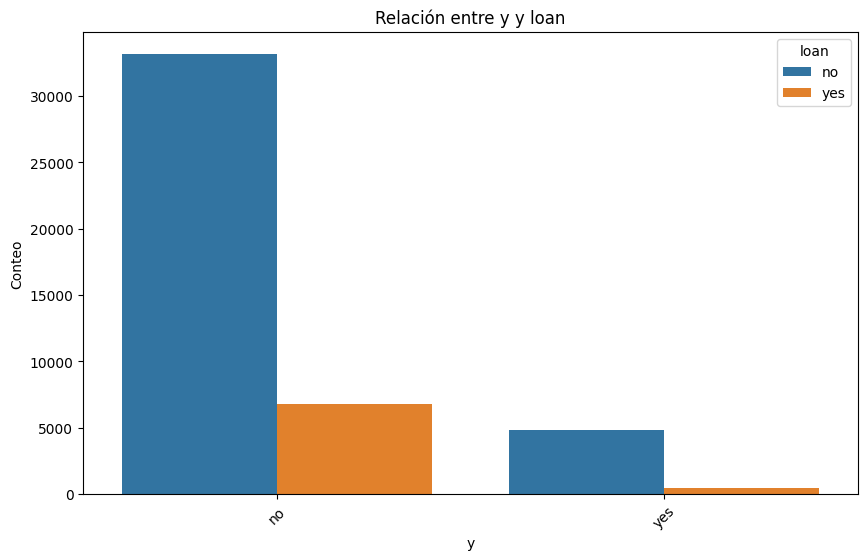

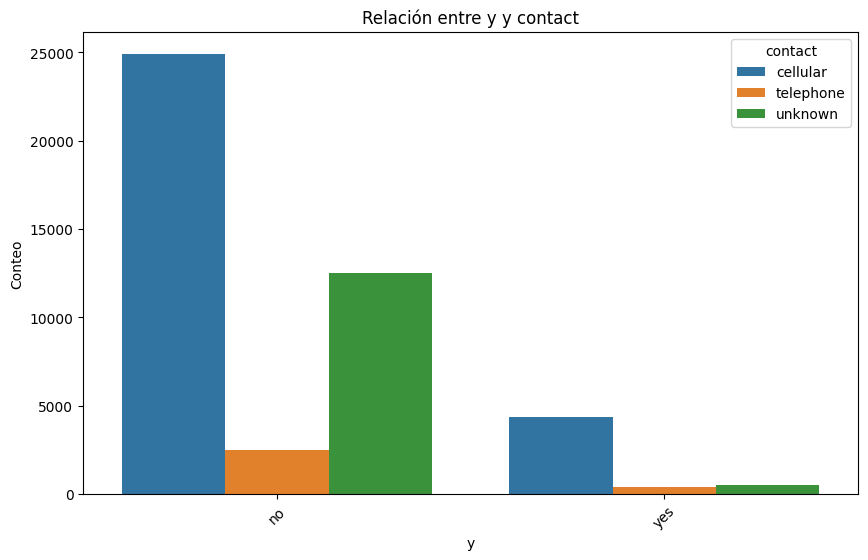

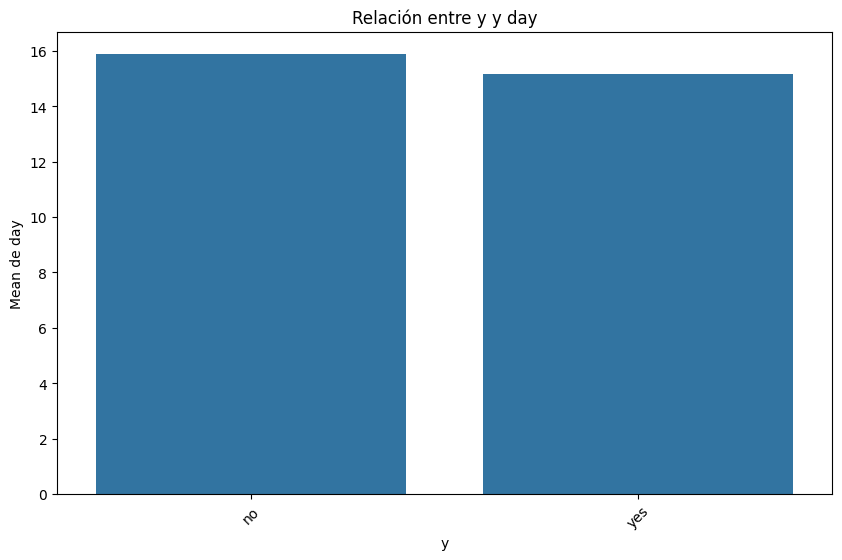

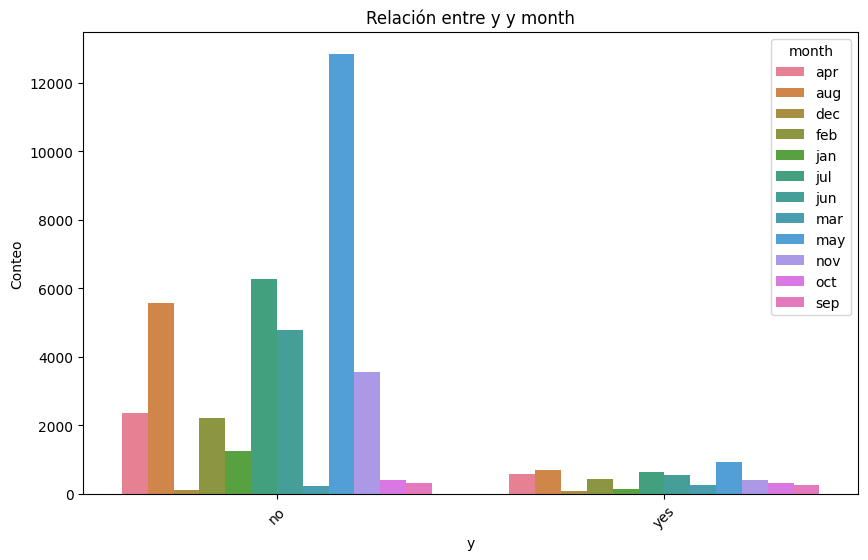

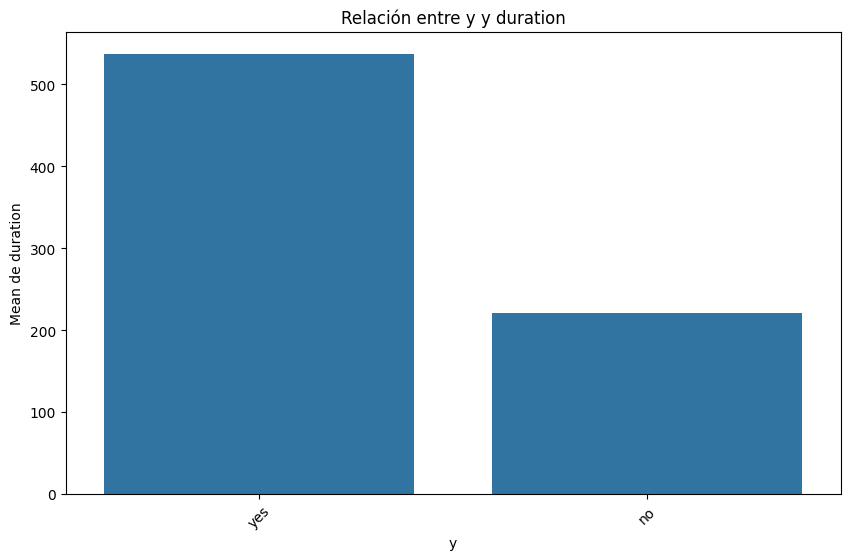

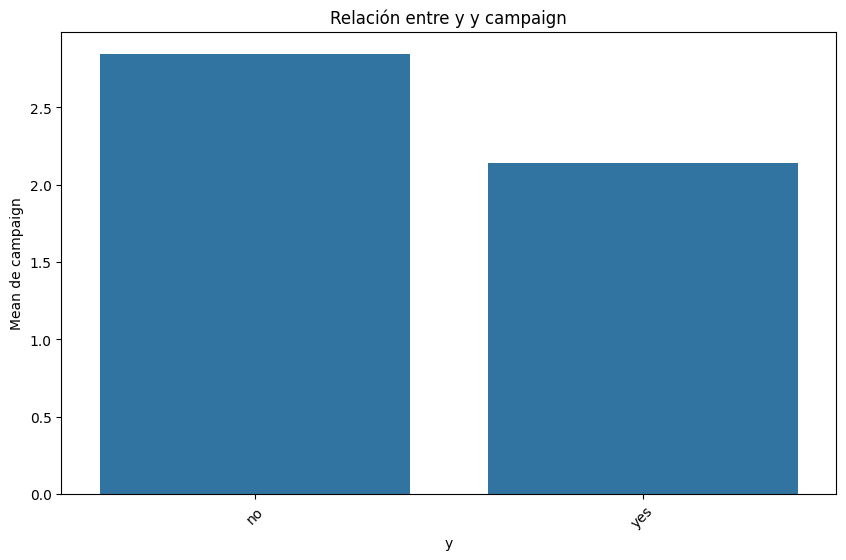

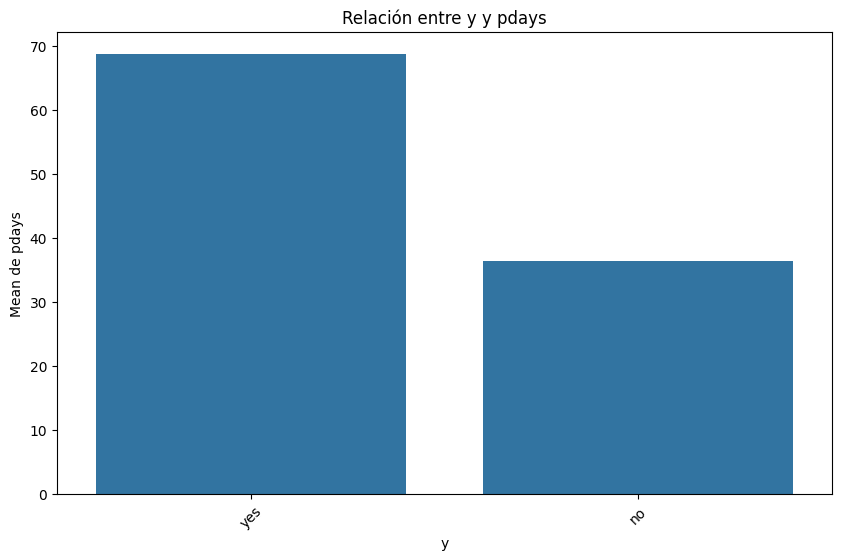

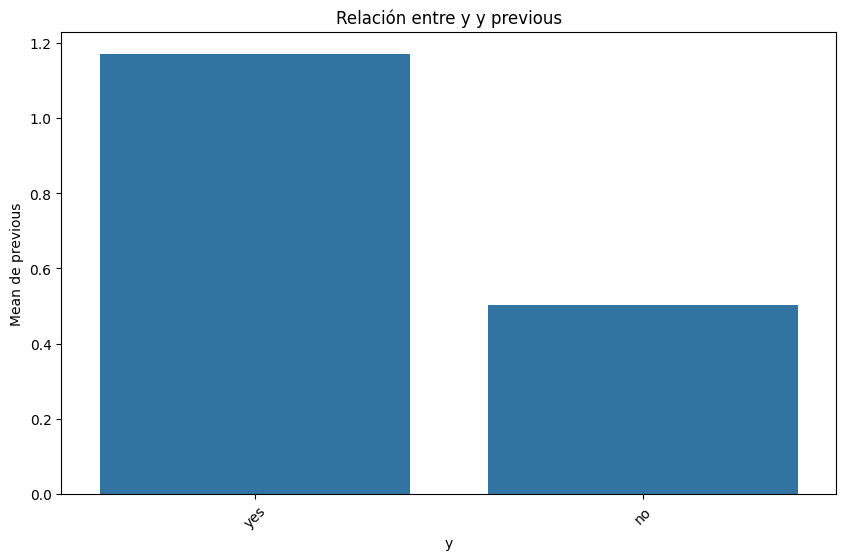

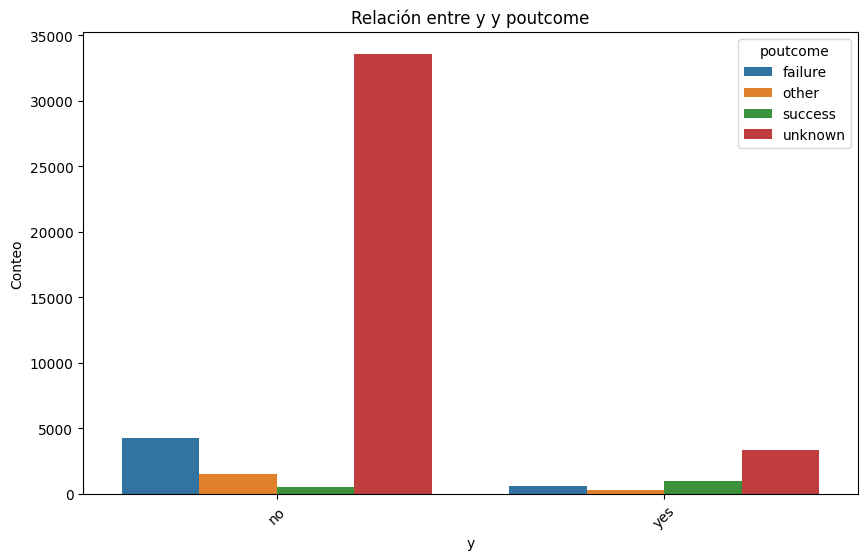

In [5]:
# Clasificamos nuestras variables

def card_tipo(df,umbral_categoria = 15, umbral_continua = 30):
    df_temp = pd.DataFrame([df.nunique(), df.nunique()/len(df) * 100, df.dtypes])
    df_temp = df_temp.T
    df_temp = df_temp.rename(columns = {0: "Card", 1: "%_Card", 2: "Tipo"})
    df_temp.loc[df_temp.Card == 1, "%_Card"] = 0.00
    df_temp["tipo_sugerido"] = "Categorica"
    df_temp.loc[df_temp["Card"] == 2, "tipo_sugerido"] = "Binaria"
    df_temp.loc[df_temp["Card"] >= umbral_categoria, "tipo_sugerido"] = "Numerica discreta"
    df_temp.loc[df_temp["%_Card"] >= umbral_continua, "tipo_sugerido"] = "Numerica continua"
    return df_temp

df_tipo = card_tipo(df)
print(df_tipo)

features_cat = []
features_num = []

for indice in df_tipo.index:
    if indice != "y":
        tipo = df_tipo.loc[indice, "tipo_sugerido"]
        if tipo in ["Binaria", "Categorica"]:
            bt.plot_categorical_relationship_fin(df, target, indice)
            features_cat.append(indice)
        elif pd.api.types.is_numeric_dtype(df[indice]):
            bt.plot_categorical_numerical_relationship(df, target, indice)
            features_num.append(indice)
        else:
            print(f"Columna '{indice}' no es numérica ni categórica reconocida. Tipo detectado: {tipo}")

4. Limpieza (no puedo imputar nulos o valores que tengan que considerar agregaciones)

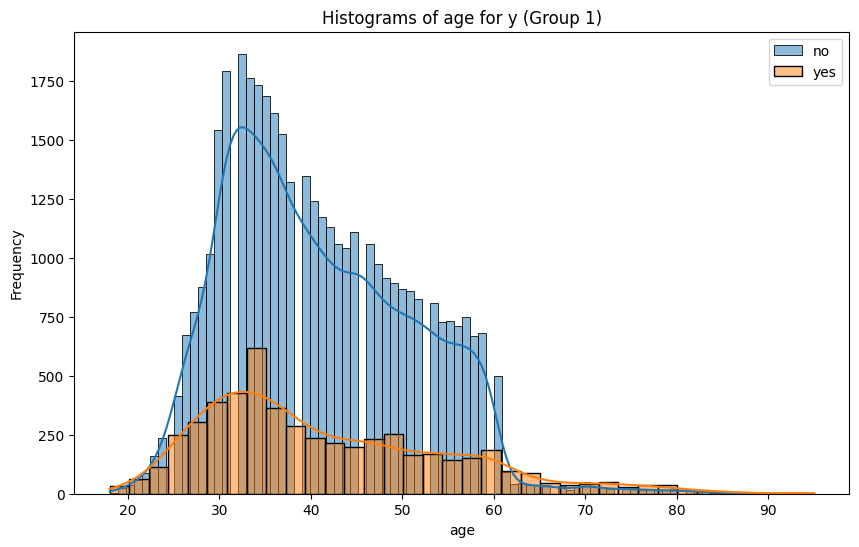

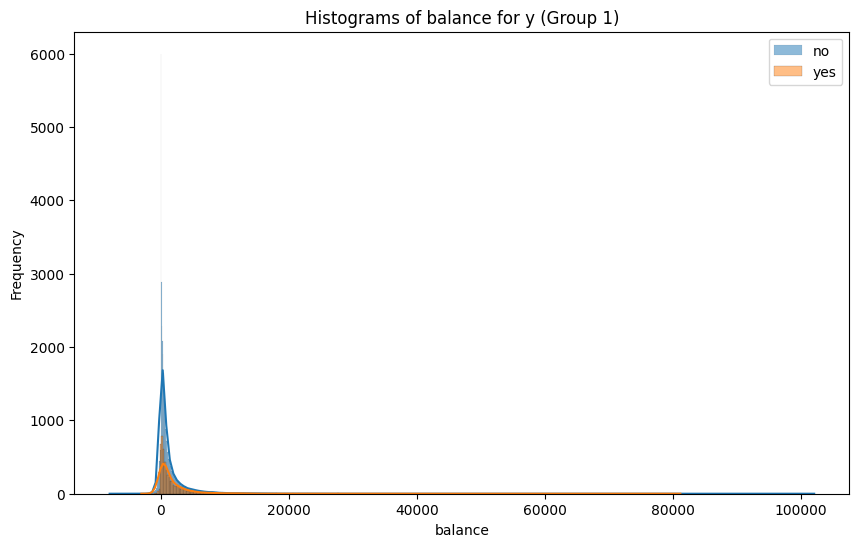

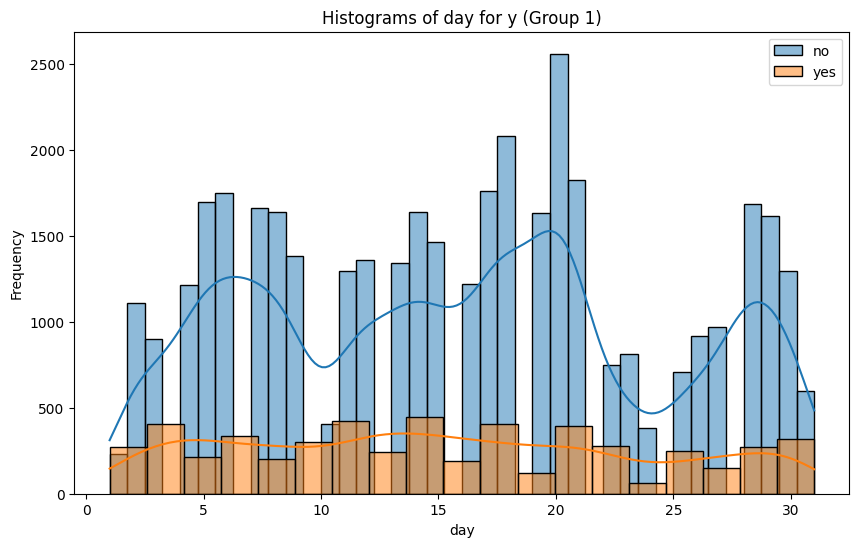

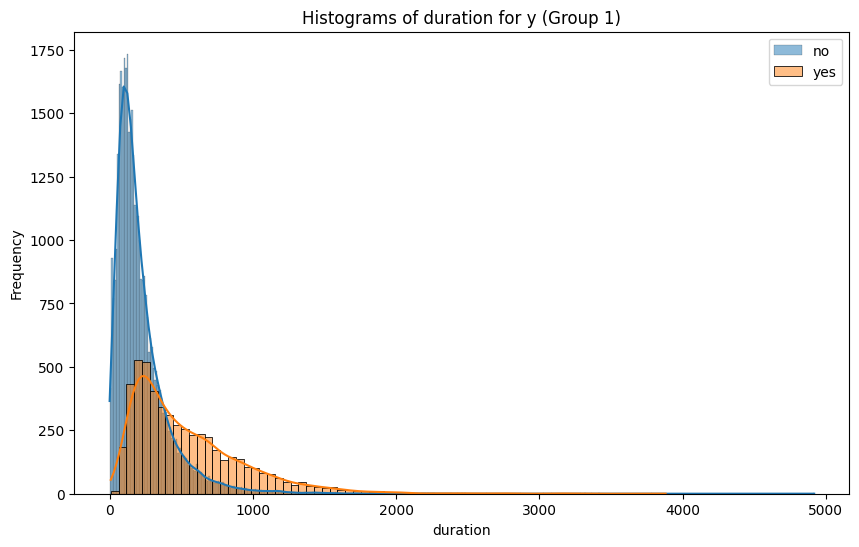

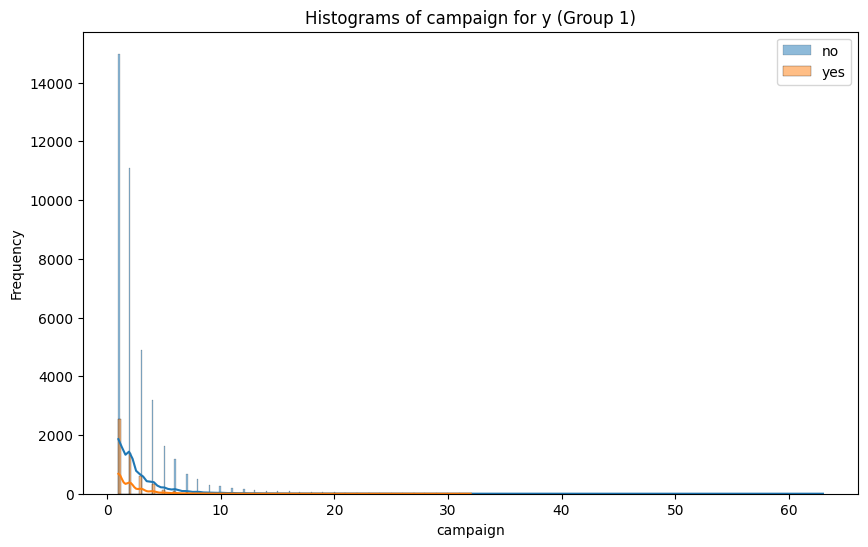

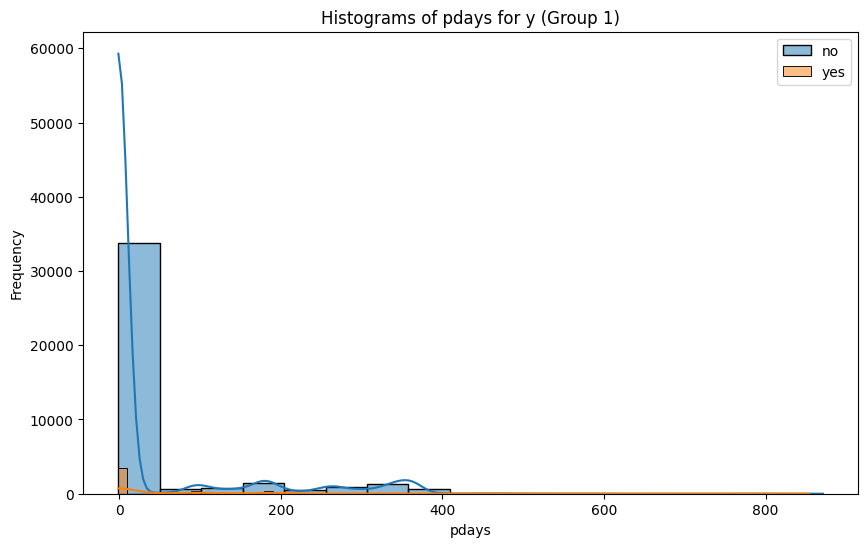

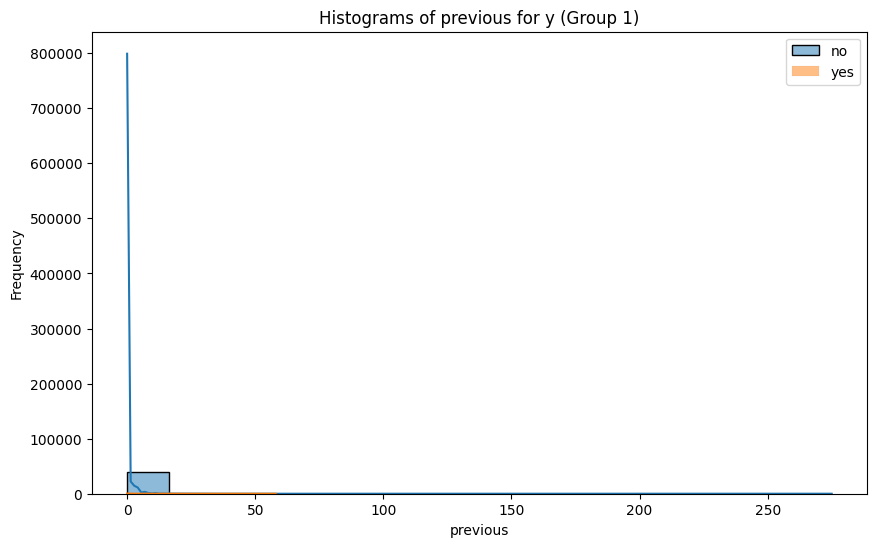

In [6]:
# Voy a a analizar en más detalle las numéricas

for numerica in features_num:
   bt.plot_grouped_histograms(df, target, numerica, group_size = 2)

5. Train/Test split

In [7]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

In [8]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36168 entries, 3344 to 15795
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        36168 non-null  int64 
 1   job        36168 non-null  object
 2   marital    36168 non-null  object
 3   education  36168 non-null  object
 4   default    36168 non-null  object
 5   balance    36168 non-null  int64 
 6   housing    36168 non-null  object
 7   loan       36168 non-null  object
 8   contact    36168 non-null  object
 9   day        36168 non-null  int64 
 10  month      36168 non-null  object
 11  duration   36168 non-null  int64 
 12  campaign   36168 non-null  int64 
 13  pdays      36168 non-null  int64 
 14  previous   36168 non-null  int64 
 15  poutcome   36168 non-null  object
 16  y          36168 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.0+ MB


In [9]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9043 entries, 3776 to 11677
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        9043 non-null   int64 
 1   job        9043 non-null   object
 2   marital    9043 non-null   object
 3   education  9043 non-null   object
 4   default    9043 non-null   object
 5   balance    9043 non-null   int64 
 6   housing    9043 non-null   object
 7   loan       9043 non-null   object
 8   contact    9043 non-null   object
 9   day        9043 non-null   int64 
 10  month      9043 non-null   object
 11  duration   9043 non-null   int64 
 12  campaign   9043 non-null   int64 
 13  pdays      9043 non-null   int64 
 14  previous   9043 non-null   int64 
 15  poutcome   9043 non-null   object
 16  y          9043 non-null   object
dtypes: int64(7), object(10)
memory usage: 1.2+ MB


6. Sobre el train ya estudio el target, la bivarianza del target con las posibles features (MiniEDA) --> lista de potenciales features

In [10]:
df_tipo

,Card,%_Card,Tipo,tipo_sugerido
age,77,0.170313,int64,Numerica discreta
job,12,0.026542,object,Categorica
marital,3,0.006636,object,Categorica
education,4,0.008847,object,Categorica
default,2,0.004424,object,Binaria
balance,7168,15.854549,int64,Numerica discreta
housing,2,0.004424,object,Binaria
loan,2,0.004424,object,Binaria
contact,3,0.006636,object,Categorica
day,31,0.068567,int64,Numerica discreta


In [11]:
features_cat

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [12]:
features_num

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

7. Tratar las features --> categóricas a numéricas, numéricas las escalo y antes las transformo

In [13]:
for feature in df_tipo.index:
    #if feature != "y":
    tipo = df_tipo.loc[feature, "tipo_sugerido"]
    if tipo == "Binaria":
        # Aplicamos la misma transformación a train y a set
        train_set[feature] = train_set[feature] == "yes"
        test_set[feature] = test_set[feature] == "yes"
    elif tipo == "Categorica":
        # Aplicamos un One-Hot encoding
        train_set = pd.get_dummies(train_set, columns=[feature], prefix=feature)
        test_set = pd.get_dummies(test_set, columns=[feature], prefix=feature)



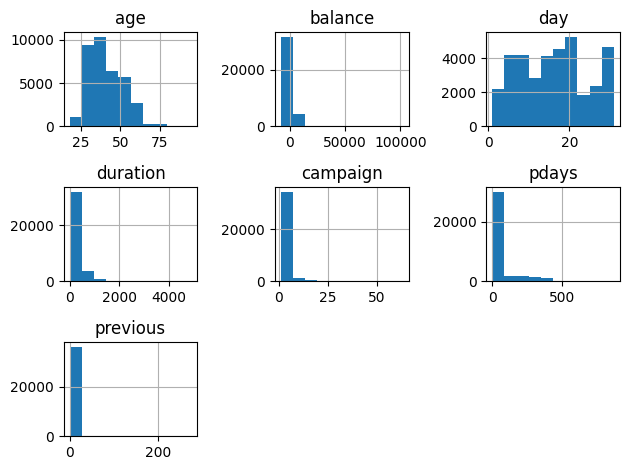

In [14]:
# Vamos con las numéricas
train_set[features_num].hist()
plt.tight_layout()

In [15]:
train_set["balance"].describe()

count     36168.000000
mean       1361.046146
std        3023.083187
min       -8019.000000
25%          70.000000
50%         447.000000
75%        1429.000000
max      102127.000000
Name: balance, dtype: float64

In [16]:
# Comprobamos las variables numéricas para evitar pérdida de datos en las transformacions
for feature in features_num:
    print(f"---- {feature} ----")
    print(train_set[feature].describe())


---- age ----
count    36168.000000
mean        40.930823
std         10.618369
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64
---- balance ----
count     36168.000000
mean       1361.046146
std        3023.083187
min       -8019.000000
25%          70.000000
50%         447.000000
75%        1429.000000
max      102127.000000
Name: balance, dtype: float64
---- day ----
count    36168.000000
mean        15.817739
std          8.325860
min          1.000000
25%          8.000000
50%         16.000000
75%         21.000000
max         31.000000
Name: day, dtype: float64
---- duration ----
count    36168.000000
mean       256.891202
std        256.884103
min          0.000000
25%        103.000000
50%        180.000000
75%        318.000000
max       4918.000000
Name: duration, dtype: float64
---- campaign ----
count    36168.000000
mean         2.765649
std          3.120193
min          1.000000
25%

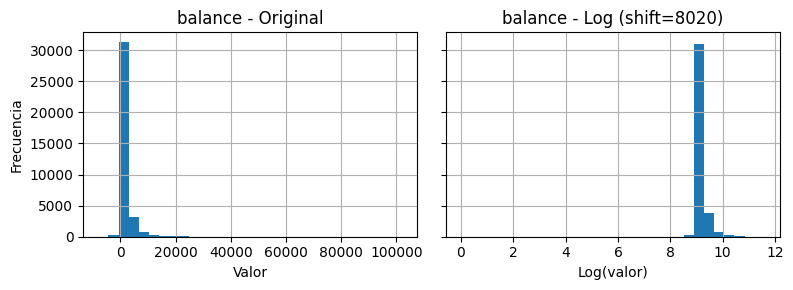

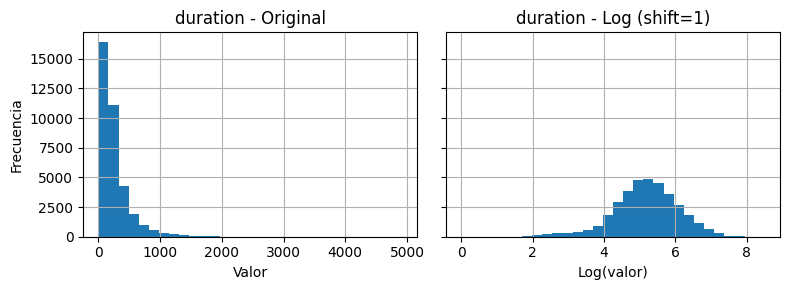

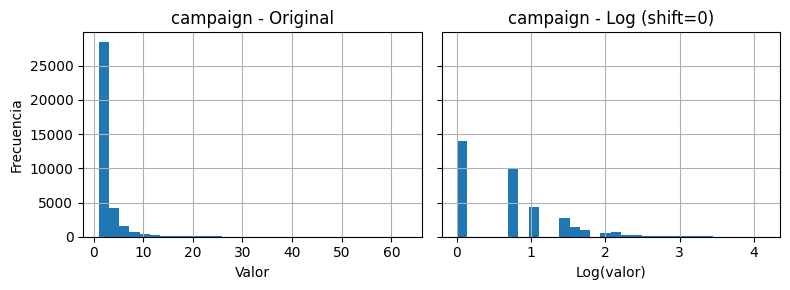

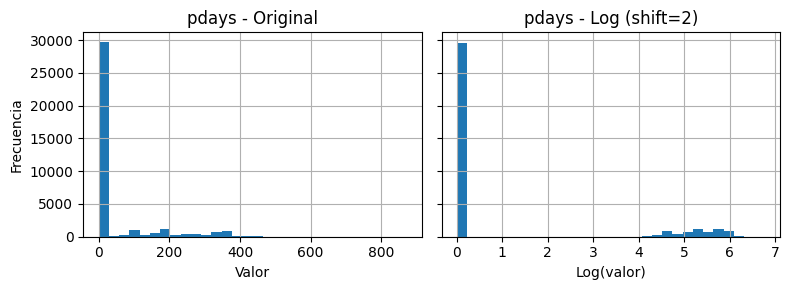

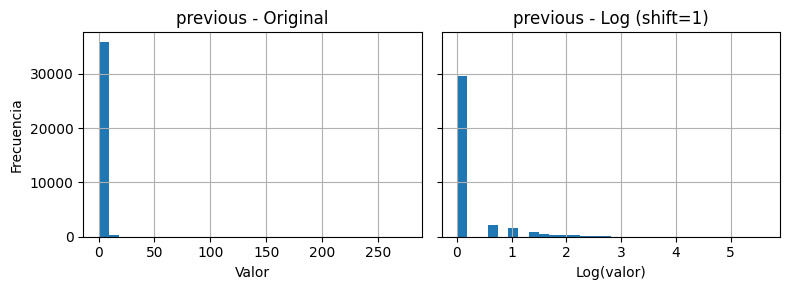

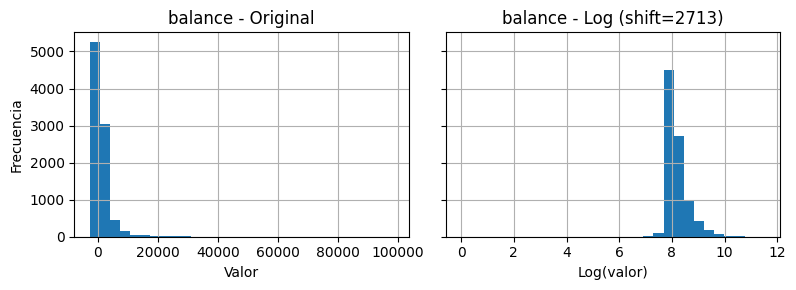

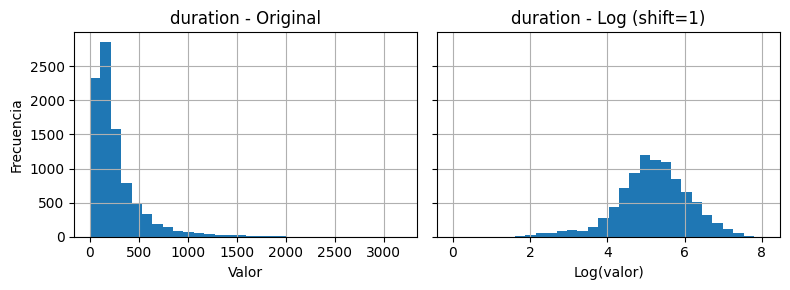

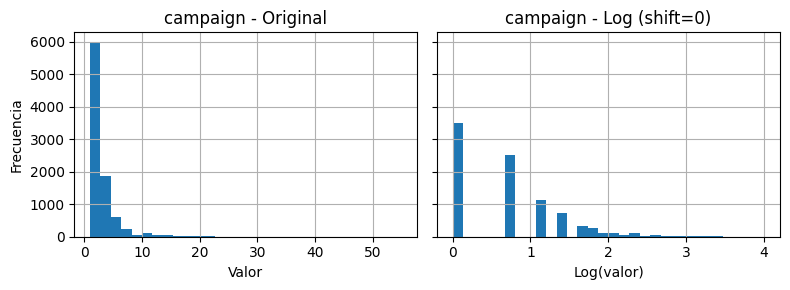

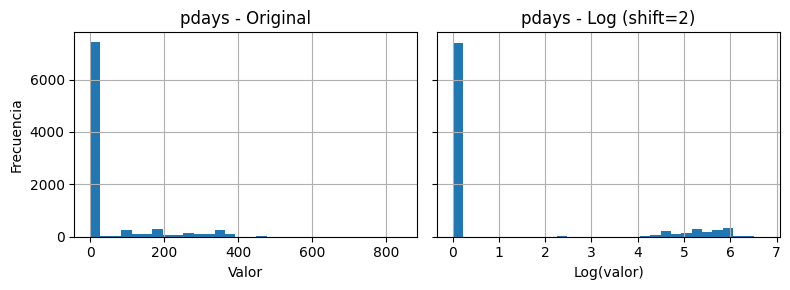

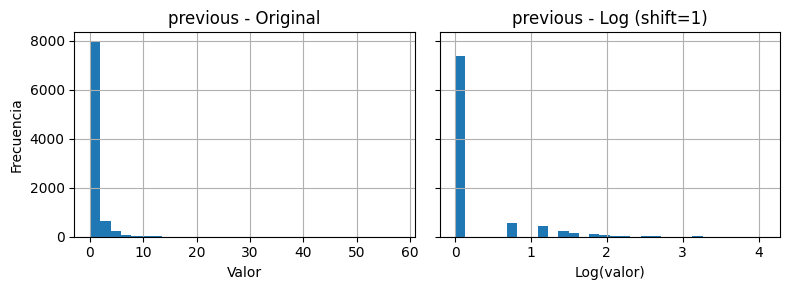

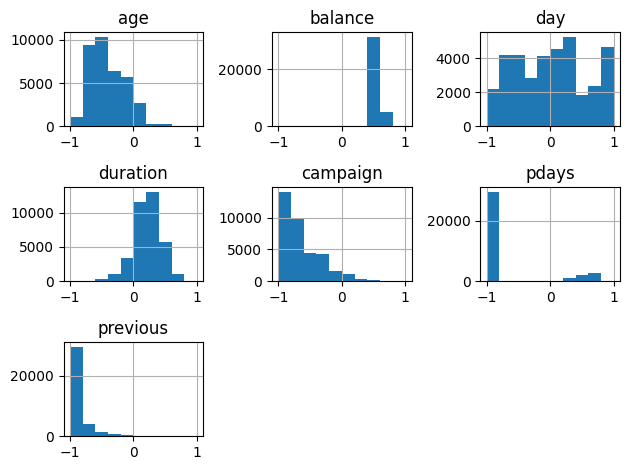

In [17]:
# Vamos realizar una transformación logística a todas mmnos "age" y "day" y luego un minmaxscaler a todas

def normalizacion(df_normalized, features_num):
    """
    Normalización de las variables numéricas al rango [-1, 1].
    """
    if isinstance(features_num, str):
        features_num = [features_num]

    for feature in features_num:
        scaled_values = MinMaxScaler(feature_range=(-1, 1)).fit_transform(df_normalized[feature].values.reshape(-1, 1))
        df_normalized[feature] = scaled_values.flatten().astype(float)
    return df_normalized

def transf_log(df_transformed, features_num, plot=True):
    """
    Aplica transformación logarítmica segura a las variables especificadas.
    Si hay valores negativos, se ajustan sumando el entero mayor necesario para que todos sean positivos.

    Parámetros:
    - df_transformed: DataFrame original.
    - features_num: Lista de columnas a transformar.
    - plot: Si True, muestra histogramas antes y después de la transformación.

    Retorna:
    - df_transformed: DataFrame con las columnas transformadas.
    """
    if isinstance(features_num, str):
        features_num = [features_num]

    df_transformed = df_transformed.copy()

    for feature in features_num:
        if plot:
            fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
            df_transformed[feature].hist(ax=axs[0], bins=30)
            axs[0].set_title(f"{feature} - Original")
            axs[0].set_xlabel("Valor")
            axs[0].set_ylabel("Frecuencia")

        min_val = df_transformed[feature].min()
        shift = 0
        if min_val <= 0:
            shift = int(abs(min_val)) + 1
            df_transformed[feature] = df_transformed[feature] + shift

        df_transformed[feature] = df_transformed[feature].apply(
            lambda x: np.log(x) if pd.notnull(x) and x > 0 else np.nan
        )

        if plot:
            df_transformed[feature].dropna().hist(ax=axs[1], bins=30)
            axs[1].set_title(f"{feature} - Log (shift={shift})")
            axs[1].set_xlabel("Log(valor)")

            plt.tight_layout()
            plt.show()

    return df_transformed


# Primero aplicamos una transformación logarítmica a aquellas variables que tienen una distribución sesgada (heavy tail).
features_log = [f for f in features_num if f not in ["age", "day"]]
train_set = transf_log(train_set, features_log)
test_set = transf_log(test_set, features_log)

# Ahora normalizamos las variables numéricas
train_set = normalizacion(train_set, features_num)
test_set = normalizacion(test_set, features_num)

train_set.hist()
plt.tight_layout()

8. Selección de un conjunto de modelos.

In [18]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9043 entries, 3776 to 11677
Data columns (total 49 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  9043 non-null   float64
 1   default              9043 non-null   bool   
 2   balance              9043 non-null   float64
 3   housing              9043 non-null   bool   
 4   loan                 9043 non-null   bool   
 5   day                  9043 non-null   float64
 6   duration             9043 non-null   float64
 7   campaign             9043 non-null   float64
 8   pdays                9043 non-null   float64
 9   previous             9043 non-null   float64
 10  y                    9043 non-null   bool   
 11  job_admin.           9043 non-null   bool   
 12  job_blue-collar      9043 non-null   bool   
 13  job_entrepreneur     9043 non-null   bool   
 14  job_housemaid        9043 non-null   bool   
 15  job_management       9043 non-null   bo

In [19]:
X_train = train_set.copy()
X_train = X_train.drop(columns=[target])
y_train = train_set[target]

X_test = test_set.copy()
X_test = X_test.drop(columns=[target])
y_test = test_set[target]

In [20]:
# Nuestro modelo baseline
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter = 5000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [21]:
print(log_reg.coef_)
print(log_reg.intercept_)
print(log_reg.classes_)

[[ 0.08691875 -0.11912252  0.25288545 -0.64925767 -0.37661117  0.17115523
   7.99856943 -0.52007542 -0.32172673  0.44014567  0.0593604  -0.26537391
  -0.27615196 -0.34994379 -0.10195482  0.15261473 -0.17247238 -0.14609101
   0.4363636  -0.15021102 -0.13277272 -0.55921698 -0.47597823 -0.65565507
  -0.37421656 -0.55521891 -0.37812958 -0.19790434 -0.37459703  0.02595955
  -0.03104223 -1.50076718 -0.20283821 -0.77549054  0.46263005 -0.34486701
  -1.44755775 -0.99961637  0.26835666  1.61231037 -0.62122203 -0.99975303
   0.79199165  0.75020635 -0.890516   -0.67638824  1.37388948 -1.3128351 ]]
[-1.73073498]
[False  True]


In [22]:
X_test = X_test[X_train.columns].copy()

from sklearn.metrics import accuracy_score
acc_train = round(accuracy_score(log_reg.predict(X_train), y_train), 3)
acc_test = round(accuracy_score(log_reg.predict(X_test), y_test), 3)
print("Accuracy train:", acc_train)
print("Accuracy test:", acc_test)

Accuracy train: 0.904
Accuracy test: 0.898


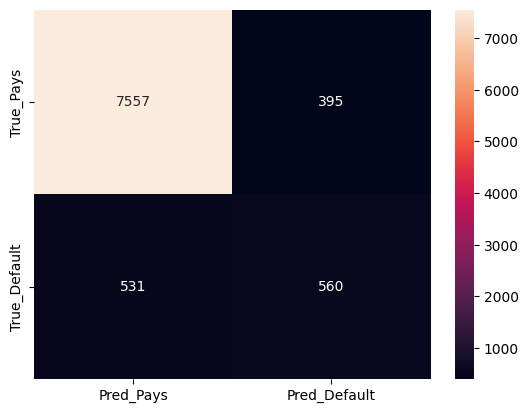

In [23]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(y_test, log_reg.predict(X_test))
c_matrix_df = pd.DataFrame(c_matrix, columns = ['Pred_Pays', 'Pred_Default'],
                          index = ['True_Pays', 'True_Default'])
sns.heatmap(c_matrix_df, annot=True, fmt='g');

c:\Users\MarioSimarroIntelaqu\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


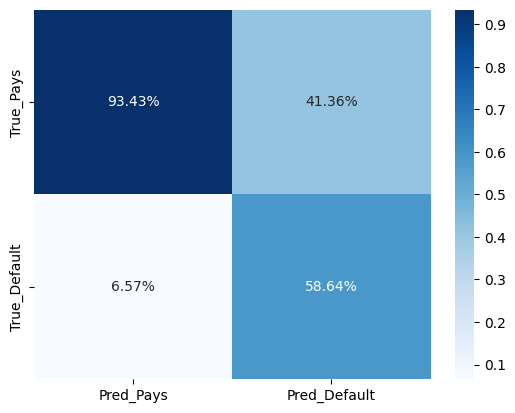

In [24]:
sns.heatmap(c_matrix_df/np.sum(c_matrix_df), annot=True, 
            fmt='.2%', cmap='Blues');

In [25]:
from sklearn.metrics import classification_report
from pprint import pprint
print(classification_report(y_train, log_reg.predict(X_train)))

              precision    recall  f1-score   support

       False       0.92      0.98      0.95     31970
        True       0.66      0.36      0.46      4198

    accuracy                           0.90     36168
   macro avg       0.79      0.67      0.70     36168
weighted avg       0.89      0.90      0.89     36168



In [26]:
print(classification_report(y_test, log_reg.predict(X_test)))

              precision    recall  f1-score   support

       False       0.93      0.95      0.94      7952
        True       0.59      0.51      0.55      1091

    accuracy                           0.90      9043
   macro avg       0.76      0.73      0.74      9043
weighted avg       0.89      0.90      0.89      9043



In [27]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state= 42)
tree_clf.fit(X_train, y_train) # Entrenamos el árbol de decisión

DecisionTreeClassifier(random_state=42)

In [28]:
print(classification_report(y_train, tree_clf.predict(X_train)))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     31970
        True       1.00      1.00      1.00      4198

    accuracy                           1.00     36168
   macro avg       1.00      1.00      1.00     36168
weighted avg       1.00      1.00      1.00     36168



In [29]:
print(classification_report(y_test, tree_clf.predict(X_test)))

              precision    recall  f1-score   support

       False       0.93      0.85      0.89      7952
        True       0.33      0.55      0.41      1091

    accuracy                           0.81      9043
   macro avg       0.63      0.70      0.65      9043
weighted avg       0.86      0.81      0.83      9043



9. Optimización de hiperparámetros de ese mejor

In [30]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
import numpy as np

In [31]:
param_grid = {
    "max_depth": [1,2,8,10],
    "min_samples_leaf": [1,10,20,100],
    "max_features": ["sqrt", "log2", None],
    "class_weight": ["balanced", None]
}

tree_clf = DecisionTreeClassifier(random_state= 42)
tree_grid = RandomizedSearchCV(tree_clf, # El modelo que quiero entrenar
                               param_grid, # El grid de parámetros
                               random_state=1, # Semilla
                               n_iter=100, # Nº de iteraciones del random search
                               cv=5, # Folds del cross validation
                               scoring="neg_root_mean_squared_error", # Métrica que quiero optimizar
                               n_jobs = -1 # Paralelizar
                               )
tree_grid.fit(X_train, y_train)

c:\Users\MarioSimarroIntelaqu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 96 is smaller than n_iter=100. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'max_depth': [1, 2, 8, 10],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 10, 20, 100]},
                   random_state=1, scoring='neg_root_mean_squared_error')

In [34]:
# Mejores parámetros del modelo
tree_grid.best_params_

{'min_samples_leaf': 100,
 'max_features': None,
 'max_depth': 8,
 'class_weight': None}

In [35]:
# Mejor score (R2)
tree_grid.best_score_**2

np.float64(0.09731564897908584)